In [ ]:
import os
import numpy as np
import pandas as pd
import keras
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import dataset ''Fashion-Mnist''

In [ ]:
data_train = pd.read_csv('/content/sample_data/fashion-mnist_train.csv')

X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape)
print('Testing', x_test.shape)

Training (42000, 28, 28, 1)
Testing (18000, 28, 28, 1)


### Split the groups

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4197, 4239, 4208, 4234, 4188, 4185, 4235, 4143, 4159, 4212]
test groups: [1803, 1761, 1792, 1766, 1812, 1815, 1765, 1857, 1841, 1788]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

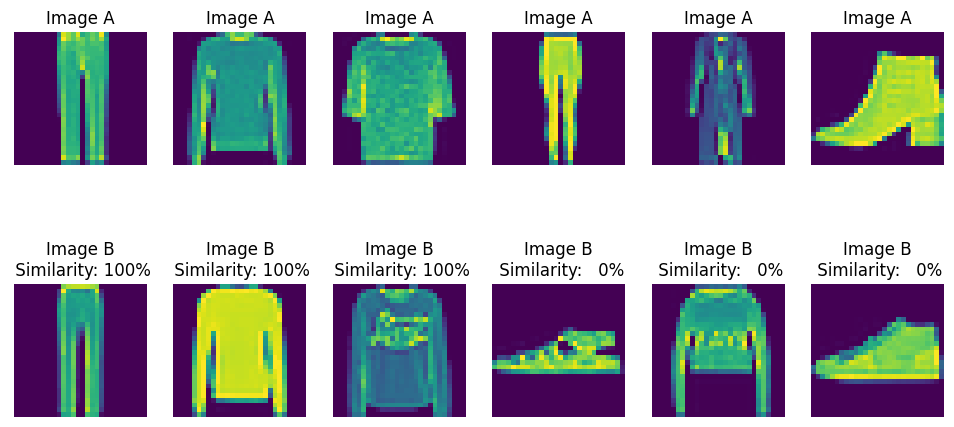

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)

fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))

for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

### Inception V-4 Model

In [ ]:
def conv2D_bn_relu(x, filters, kernel_size, strides, padding='valid', kernel_initializer='glorot_uniform', name=None):

    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                      kernel_initializer=kernel_initializer,
                      name=name,
                      use_bias=False)(x)
    x = layers.BatchNormalization(scale=False)(x)
    return layers.Activation('relu')(x)


def inception_module_A(x, filters=None, kernel_initializer='glorot_uniform'):

    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 4

    b1 = conv2D_bn_relu(x,
                        filters=(branch_filters // 3) * 2,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)
    b1 = conv2D_bn_relu(b1,
                        filters=branch_filters,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)

    b2 = conv2D_bn_relu(x,
                        filters=(branch_filters // 3) * 2,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=branch_filters,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=branch_filters,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)

    b3 = conv2D_bn_relu(x,
                        filters=branch_filters,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)

    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D_bn_relu(pool,
                          filters=branch_filters,
                          kernel_size=1,
                          strides=1,
                          kernel_initializer=kernel_initializer)

    return layers.concatenate([b1, b2, b3, pool])


def inception_module_C(x, filters=None, kernel_initializer='glorot_uniform'):
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 6

    b1 = conv2D_bn_relu(x,
                        filters=(branch_filters // 2) * 3,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)

    b1a = conv2D_bn_relu(b1,
                         filters=branch_filters,
                         kernel_size=(1, 3),
                         strides=1,
                         padding='same',
                         kernel_initializer=kernel_initializer)

    b1b = conv2D_bn_relu(b1,
                         filters=branch_filters,
                         kernel_size=(3, 1),
                         strides=1,
                         padding='same',
                         kernel_initializer=kernel_initializer)

    b2 = conv2D_bn_relu(x,
                        filters=(branch_filters // 2) * 3,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=(branch_filters // 4) * 7,
                        kernel_size=(1, 3),
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=branch_filters * 2,
                        kernel_size=(3, 1),
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)

    b2a = conv2D_bn_relu(b2,
                         filters=branch_filters,
                         kernel_size=(1, 3),
                         strides=1,
                         padding='same',
                         kernel_initializer=kernel_initializer)

    b2b = conv2D_bn_relu(b2,
                         branch_filters,
                         kernel_size=(3, 1),
                         strides=1,
                         padding='same',
                         kernel_initializer=kernel_initializer)

    b3 = conv2D_bn_relu(x,
                        filters=branch_filters,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)

    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D_bn_relu(pool,
                          filters=branch_filters,
                          kernel_size=1,
                          strides=1,
                          kernel_initializer=kernel_initializer)

    return layers.concatenate([b1a, b1b, b2a, b2b, b3, pool])


def reduction_module_A(x, filters, kernel_initializer='glorot_uniform'):

    branch_filters = (filters - int(x.shape[-1])) // 2

    b1 = conv2D_bn_relu(x,
                        filters=branch_filters,
                        kernel_size=3,
                        strides=2,
                        padding='same',
                        kernel_initializer=kernel_initializer)

    b2 = conv2D_bn_relu(x,
                        filters=(branch_filters // 3) * 2,
                        kernel_size=1,
                        strides=1,
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=(branch_filters // 6) * 5,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        kernel_initializer=kernel_initializer)
    b2 = conv2D_bn_relu(b2,
                        filters=branch_filters,
                        kernel_size=3,
                        strides=2,
                        padding='same',
                        kernel_initializer=kernel_initializer)

    pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    return layers.concatenate([b1, b2, pool])

In [ ]:
stem_width = 128

inputs = layers.Input(shape=x_train.shape[1:])
x = conv2D_bn_relu(inputs,
                   filters=stem_width,
                   kernel_size=5,
                   strides=1,
                   padding='same',
                   name='conv_1')

x = reduction_module_A(x, filters=int(2*stem_width))
x = layers.SpatialDropout2D(0.3)(x)

x = inception_module_A(x, filters=int(2*stem_width))
x = inception_module_A(x, filters=int(2*stem_width))

x = reduction_module_A(x, filters=int(3*stem_width))
x = layers.SpatialDropout2D(0.5)(x)

x = inception_module_C(x, filters=int(3*stem_width))
x = inception_module_C(x, filters=int(3*stem_width))
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(32)(x)
# x = layers.Activation('softmax', name='softmax')(x)

model = keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 28, 28, 128)  3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_45 (BatchN  (None, 28, 28, 128)  384        ['conv_1[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 28, 28, 128)  0           ['batch_normalization_45[0]

### Siamese Model

In [ ]:
from keras.layers import concatenate, Dense, Input
from tensorflow.keras.layers import BatchNormalization, Activation


img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = keras.Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 32)           1204616     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['model_1[0][0]', 

In [ ]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

1/1 [==============================] - 1s 1s/step


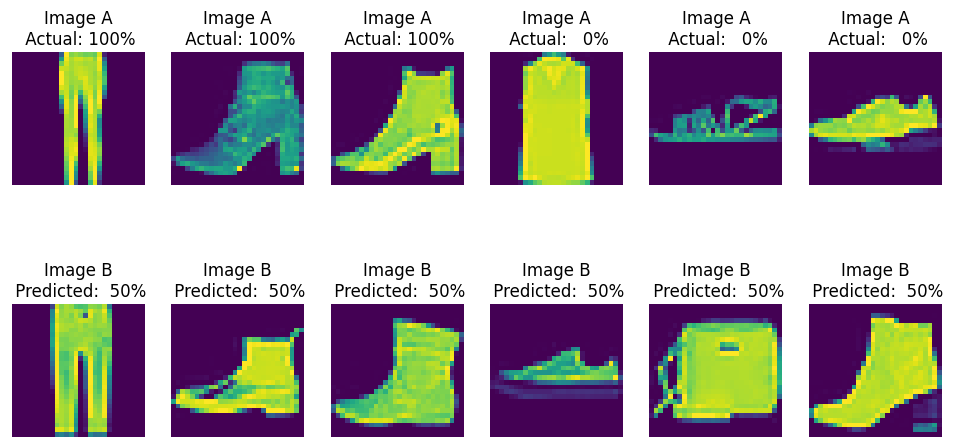

In [ ]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
  # a completely untrained model
_ = show_model_output()

In [ ]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                                    steps_per_epoch = 10,
                                    validation_data=([valid_a, valid_b], valid_sim),
                                    epochs = 5,
                                    verbose = True)

Epoch 1/5
10/10 [==============================] - 81s 7s/step - loss: 0.7863 - mae: 0.5003 - val_loss: 0.6940 - val_mae: 0.5000
Epoch 2/5
10/10 [==============================] - 48s 5s/step - loss: 0.7897 - mae: 0.5012 - val_loss: 0.6965 - val_mae: 0.5000
Epoch 3/5
10/10 [==============================] - 51s 5s/step - loss: 0.7544 - mae: 0.4904 - val_loss: 0.6952 - val_mae: 0.5000
Epoch 4/5
10/10 [==============================] - 62s 7s/step - loss: 0.7455 - mae: 0.4923 - val_loss: 0.6952 - val_mae: 0.5001
Epoch 5/5
10/10 [==============================] - 65s 7s/step - loss: 0.7521 - mae: 0.5005 - val_loss: 0.6980 - val_mae: 0.5002


1/1 [==============================] - 0s 93ms/step


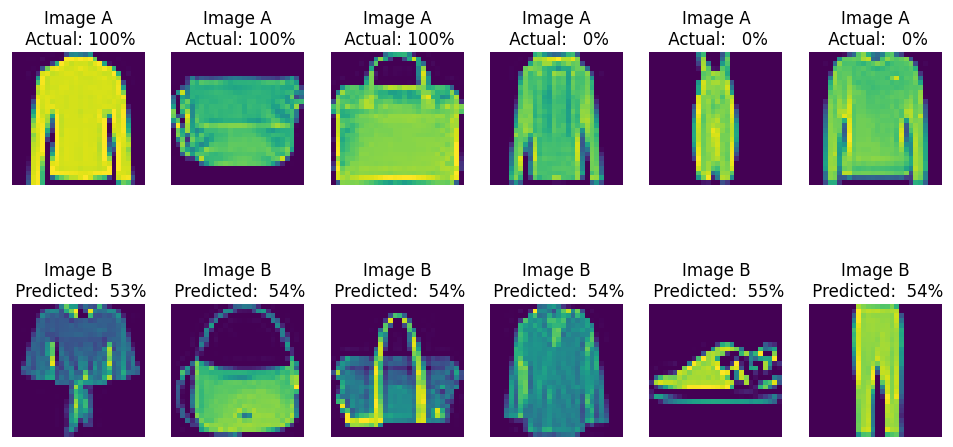

In [ ]:
_ = show_model_output()

### Vizualization with t-SNE

In [ ]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

129/129 [==============================] - 114s 880ms/step


In [ ]:
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

x_train_2d = x_train.reshape((x_train.shape[0], -1))

# Create a SimpleImputer object to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both the training and test data
x_train_imputed_2d = imputer.fit_transform(x_train_2d)
x_test_imputed_2d = imputer.transform(x_test.reshape((x_test.shape[0], -1)))

# Apply TSNE to the imputed test data
tsne = TSNE(n_components=2, init='pca', random_state=101, method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne.fit_transform(x_test_imputed_2d)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16458 samples in 0.077s...
[t-SNE] Computed neighbors for 16458 samples in 15.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16458
[t-SNE] Computed conditional probabilities for sample 2000 / 16458
[t-SNE] Computed conditional probabilities for sample 3000 / 16458
[t-SNE] Computed conditional probabilities for sample 4000 / 16458
[t-SNE] Computed conditional probabilities for sample 5000 / 16458
[t-SNE] Computed conditional probabilities for sample 6000 / 16458
[t-SNE] Computed conditional probabilities for sample 7000 / 16458
[t-SNE] Computed conditional probabilities for sample 8000 / 16458
[t-SNE] Computed conditional probabilities for sample 9000 / 16458
[t-SNE] Computed conditional probabilities for sample 10000 / 16458
[t-SNE] Computed conditional probabilities for sample 11000 / 16458
[t-SNE] Computed conditional probabilities for sample 12000 / 16458
[t-SNE] Computed conditional probabilities for sa

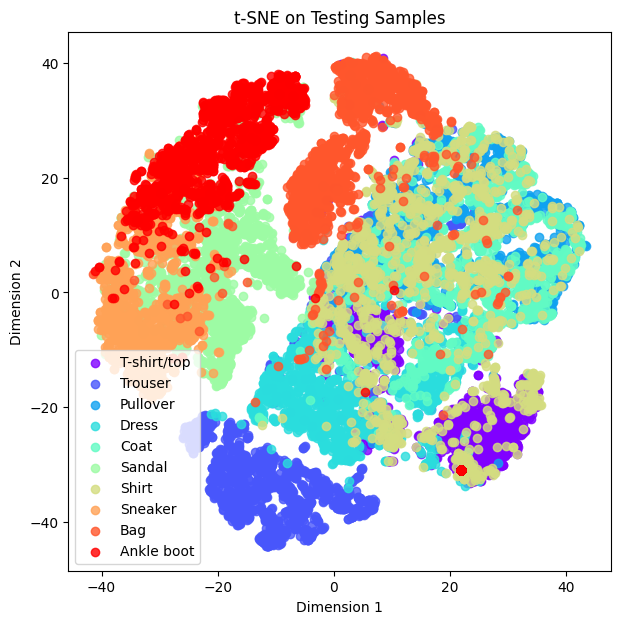

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

plt.figure(figsize=(7, 7))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
              color=c_color,
              linewidth=1,
              alpha=0.8,
              label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)